# Movie Recommendation System

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
u_cols = ['movieId','title','genres']
movie = pd.read_csv('movies.dat', sep='::', names=u_cols,encoding='latin-1', engine='python')
print("\nMovie Data :")
print("shape : ", movie.shape)


Movie Data :
shape :  (3883, 3)


In [9]:
movie.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [17]:
r_cols = ['user_id', 'movieId', 'rating', 'unix_timestamp']
rating = pd.read_csv('ratings.dat', sep='::', names=r_cols,encoding='latin-1', engine='python')
print("\nRatings Data :")
print("shape : ", rating.shape)


Ratings Data :
shape :  (1000209, 4)


In [18]:
print(movie.shape)
print(rating.shape)

(3883, 3)
(1000209, 4)


In [19]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [20]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   user_id         1000209 non-null  int64
 1   movieId         1000209 non-null  int64
 2   rating          1000209 non-null  int64
 3   unix_timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [21]:
movie.describe()

,movieId
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [22]:
movie.describe(include='O')

,title,genres
count,3883,3883
unique,3883,301
top,Toy Story (1995),Drama
freq,1,843


In [23]:
df = pd.merge(movie,rating,on='movieId')

In [24]:
df.isnull().sum()

movieId           0
title             0
genres            0
user_id           0
rating            0
unix_timestamp    0
dtype: int64

In [25]:
movie.movieId.nunique()

3883

In [27]:
rating.user_id.nunique()

6040

In [28]:
print(movie.shape)
print(rating.shape)
print(df.shape)

(3883, 3)
(1000209, 4)
(1000209, 6)


From the above three lines of code output, we came to know that there are 10329 unique movies and 668 unique users are there to rate the movies. So, the final merged dataframe contains 105339 rows because a single movie can be rated by many users or viceversa. So that the length of rows increased.

In [29]:
df.head(10)

,movieId,title,genres,user_id,rating,unix_timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474
5,1,Toy Story (1995),Animation|Children's|Comedy,18,4,978154768
6,1,Toy Story (1995),Animation|Children's|Comedy,19,5,978555994
7,1,Toy Story (1995),Animation|Children's|Comedy,21,3,978139347
8,1,Toy Story (1995),Animation|Children's|Comedy,23,4,978463614
9,1,Toy Story (1995),Animation|Children's|Comedy,26,3,978130703


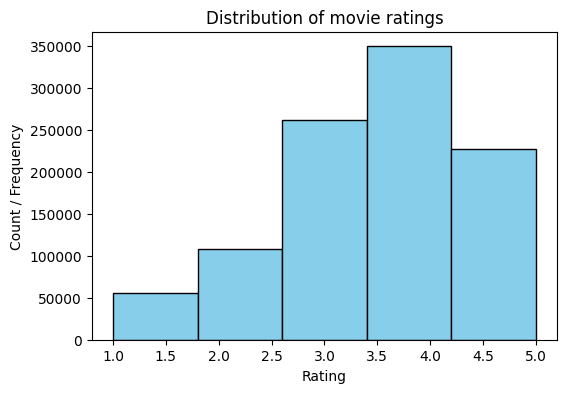

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(x=df['rating'],bins=5,color='skyblue',edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count / Frequency')
plt.title('Distribution of movie ratings')

plt.show()

In [31]:
all_genres = df['genres'].str.split('|').explode()
unique_genres = all_genres.unique()
# print(unique_genres)

In [46]:
# Function to filter by Genre with error handling
def filter_by_genre(df, genre):
    if genre not in unique_genres:
        log_event('error', f"Genre '{genre}' not found in available genres.")
        print(f"Error: Genre '{genre}' not available. Please choose another genre.")
        return pd.DataFrame()  # Return an empty DataFrame if genre is invalid
    return df[df['genres'].str.contains(genre, case=False, na=False)]

# Example usage in the recommend_movies function
def recommend_movies(genre, min_reviews, num_recommendations):
    # Filter movies by genre
    genre_movies = filter_by_genre(df, genre)
    
    if genre_movies.empty:
        return None  # No recommendations if genre was invalid or empty

    # Calculate popularity metrics
    popularity = calculate_popularity(genre_movies)
    
    # Filter by minimum reviews threshold
    filtered_popularity = filter_by_threshold(popularity, min_reviews)
    
    # Get top N recommendations
    top_n = get_top_n_recommendations(filtered_popularity, num_recommendations)
    
    # Merge with movie titles
    top_n = top_n.merge(movie[['movieId', 'title']], on='movieId')
    
    return top_n[['title', 'average_rating', 'rating_count']]

# Try-catch for genre selection
try:
    genre_choice = int(input("Enter genre number: "))
    selected_genre = unique_genres[genre_choice - 1]
    log_event('info', f"Genre selected: {selected_genre}")
    
    min_reviews = int(input('Minimum reviews: '))
    num_recommendations = int(input('Number of recommendations: '))
    recommendations = recommend_movies(selected_genre, min_reviews, num_recommendations)
    
    if recommendations is not None:
        print("Recommendations:", recommendations)
    else:
        log_event('info', "No recommendations generated due to invalid genre.")

except ValueError as e:
    log_event('error', f"Input error: {e}")


Enter genre number:  11
Minimum reviews:  200
Number of recommendations:  5


Recommendations:                        title  average_rating  rating_count
0  Young Frankenstein (1974)        4.250629          1193
1              Psycho (1960)        4.218527          1263
2               Alien (1979)        4.159585          2024
3        Shining, The (1980)        4.104876          1087
4                Jaws (1975)        4.089570          1697


### <center><span style="color:green;">Popularity Based Recommendation System</span></center>

In [33]:
print("Available genres:")
print('=================')
for i, genre in enumerate(unique_genres,1):
    print(f"{i}. {genre}")

    #Function to filter by Genre
def filter_by_genre(df, genre):
    return df[df['genres'].str.contains(genre, case=False, na=False)]

#Function to calculate Average ratings and count of ratings
def calculate_popularity(df):
    # Group by movieId and calculate average rating and count of ratings
    popularity = df.groupby('movieId').agg({'rating': ['mean', 'count']})
    # Rename columns
    popularity.columns = ['average_rating', 'rating_count']
    return popularity

#Function to filter by minimum reviews threshold
def filter_by_threshold(df, threshold):
    return df[df['rating_count'] >= threshold]

#Function to get Top N Recommendations
def get_top_n_recommendations(df, n):
    return df.sort_values(by='average_rating', ascending=False).head(n)

#Function to Recommend:
def recommend_movies(genre, min_reviews, num_recommendations):
    # Filter movies by genre
    genre_movies = filter_by_genre(df, genre)
    # Calculate popularity metrics
    popularity = calculate_popularity(genre_movies)
    # Filter by minimum reviews threshold
    filtered_popularity = filter_by_threshold(popularity, min_reviews)
    # Get top N recommendations
    top_n = get_top_n_recommendations(filtered_popularity, num_recommendations)
    # Merge with movie titles
    top_n = top_n.merge(movie[['movieId', 'title']], on='movieId')
    return top_n[['title', 'average_rating', 'rating_count']]

genre_choice = int(input("Enter the number corresponding to your preferred genre: "))
selected_genre = unique_genres[genre_choice - 1]
print('--------------------------')
print(f"You selected: {selected_genre}")
print('--------------------------')
min_reviews = int(input('Enter the minimum review:'))
print('--------------------------')
num_recommendations = int(input('Enter the number of Recommendations:'))
print('--------------------------')
recommendations=recommend_movies(selected_genre,min_reviews,num_recommendations)
display(recommendations)

Available genres:
1. Animation
2. Children's
3. Comedy
4. Adventure
5. Fantasy
6. Romance
7. Drama
8. Action
9. Crime
10. Thriller
11. Horror
12. Sci-Fi
13. Documentary
14. War
15. Musical
16. Mystery
17. Film-Noir
18. Western


Enter the number corresponding to your preferred genre:  11


--------------------------
You selected: Horror
--------------------------


Enter the minimum review: 200


--------------------------


Enter the number of Recommendations: 5


--------------------------


,title,average_rating,rating_count
0,Young Frankenstein (1974),4.250629,1193
1,Psycho (1960),4.218527,1263
2,Alien (1979),4.159585,2024
3,"Shining, The (1980)",4.104876,1087
4,Jaws (1975),4.089570,1697


### <center><span style="color:green;">Content Based Recommendation System</span></center>

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

df_crs = movie.iloc[:,1:]

# Create a count matrix
count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
count_matrix = count_vectorizer.fit_transform(df_crs['genres'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix,count_matrix)

def get_recommendations(title, N):
    # Get the index of the movie that matches the title
    idx = df_crs[df_crs['title'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top N most similar movies
    sim_scores = sim_scores[1:N+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top N most similar movies
    return df_crs['title'].iloc[movie_indices]

In [38]:
title_df = pd.DataFrame(data= df['title'].unique(),columns=['Title'])
while True:
    name_like = input('Your Search: ')
    print("====================================================================================")
    filtered_df = title_df[title_df['Title'].str.startswith(name_like)]
    
    if not filtered_df.empty:
        print('Results:')
        display(filtered_df)
        break
    else:
        print("""Movies not Found!
Because your search is case sensitive. So, Take a look at your Search""")
print("----------------------------------------------------------------------------------------")
movie_title = input("Now, search for Similiar movies by copying from results: ")
print("----------------------------------------------------------------------------------------")
num_recom = int(input('Number of Recommendations you want: '))
recommended_movies = get_recommendations(movie_title, num_recom)
print("========================================================================================")
print(f"Similiar {num_recom} movies of {movie_title}")
display(recommended_movies)

Your Search:  Horror Express


Results:


,Title
3257,Horror Express (1972)


----------------------------------------------------------------------------------------


Now, search for Similiar movies by copying from results:  Horror Express


----------------------------------------------------------------------------------------


Number of Recommendations you want:  c0


ValueError: invalid literal for int() with base 10: 'c0'

### <center><span style="color:green;">Collaborative Based Recommendation System</span></center>

In [40]:
user_item_matrix = rating.pivot(index='user_id', columns='movieId', values='rating').fillna(0)
#user_item_matrix

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
def find_similar_users(user_id, k=100):
    user_vector = user_item_matrix.loc[user_id].values.reshape(1, -1)
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(user_item_matrix)
    distances, indices = knn.kneighbors(user_vector)
    similar_users = user_item_matrix.index[indices.flatten()].tolist()
    return similar_users

In [42]:
def recommend_movies(user_id, n=5, k=100):
    similar_users = find_similar_users(user_id, k)
    similar_users_ratings = user_item_matrix.loc[similar_users].mean(axis=0)
    user_ratings = user_item_matrix.loc[user_id]
    recommendations = similar_users_ratings[user_ratings == 0].sort_values(ascending=False).head(n)
    return recommendations.index.tolist()

# Inputs for the recommender
user_id = int(input('Enter userid between 1 and 668: '))
num_recommendations = int(input('Enter number of Recommendations you want: '))
threshold_similar_users = 100

recommended_movies = recommend_movies(user_id, num_recommendations, threshold_similar_users)
recommended_movie = pd.DataFrame(movie.loc[recommended_movies,'title'])
print("================================================================================")
print(f"Recommended movies for UserId {user_id} are")
display(recommended_movie)

Enter userid between 1 and 668:  25
Enter number of Recommendations you want:  5


Recommended movies for UserId 25 are


,title
589,"Silence of the Lambs, The (1991)"
1240,M (1931)
2916,Robocop (1987)
316,Shallow Grave (1994)
1527,"Last Time I Committed Suicide, The (1997)"
